# test_project_uw

using modal mooring

In [143]:
%matplotlib notebook
from matplotlib import pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.basemap import Basemap

import sys
import numpy as np
import scipy.signal as sig
from scipy.ndimage import gaussian_filter
from netCDF4 import Dataset, MFDataset
from emooring import emooring
import gsw
import R_tools_fort as toolsf

KRYPTON = "/data0/project/vortex/lahaye/"

In [151]:
filepath = KRYPTON+"luckym2_modemap/luckym2_modemap_20.nc"
filenrj = filepath.replace('map_','nrj_')
filcol = KRYPTON+"moorings_from_simus/luckym2_column_i1027_j0968.nc"
filgrid = KRYPTON+"lucky_corgrd.nc"
it = 360

0 256 241 1 0


<IPython.core.display.Javascript object>


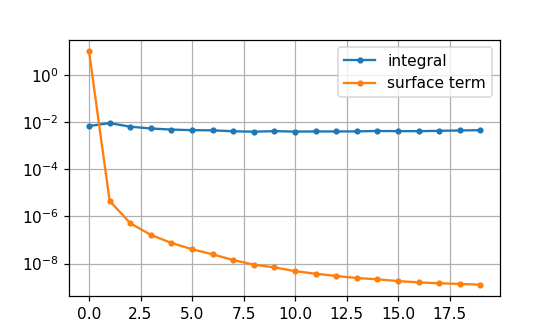

In [154]:
nc = Dataset(filepath,"r")
xi = nc.variables['xi_rho'][:]
eta= nc.variables['eta_rho'][:]
lon = nc.variables['lon_rho'][:]
lat = nc.variables['lat_rho'][:]
topo = nc.variables['topo'][:]
time = nc.variables['time'][it]
otime = nc.variables['ocean_time'][it]
nc.close()

nc = Dataset(filgrid, "r")
f0 = nc.variables['f'][:].mean()
nc.close()

simul = emooring(filcol)
itsim = abs(simul.time-time).argmin()
coords = simul.hcoord_section
xiok = np.where((xi>=coords[0]) & (xi<coords[1]))[0][0]
etok = np.where((eta>=coords[2]) & (eta<coords[3]))[0][0]

nc = Dataset(filepath,"r")
uamp = nc.variables['u_amp'][it,:,etok, xiok]
vamp = nc.variables['v_amp'][it,:,etok, xiok]
pmod = nc.variables['p_modes'][:,:,etok,xiok]
wamp = nc.variables['w_amp'][it,:,etok, xiok]
wmod = nc.variables['w_modes'][:,:,etok,xiok]
bamp = nc.variables['b_amp'][it,:,etok,xiok]
nsqb = nc.variables['Nsqb'][:,etok,xiok]
bbaz = nc.variables['bbase'][:,etok,xiok]
cphi = nc.variables['mode_speed'][:,etok,xiok]
nc.close()

nc = Dataset(filenrj,"r")
pemod = nc.variables['ep'][it,:,etok,xiok]
kemod = nc.variables['ek'][it,:,etok,xiok]
nc.close()

isim, jsim = xi[xiok]-coords[0], eta[etok]-coords[2]
print(itsim, xiok, etok, isim, jsim)
grav = 9.81

zr = simul.zrb[:,jsim,isim]
zw = simul.zwb[:,jsim,isim]

pnorm = (pmod**2*np.diff(zw)[None,:]).sum(axis=1)
wnorm = np.trapz(wmod**2*nsqb[None,:], zw, axis=1) + grav*wmod[:,-1]**2

plt.figure(figsize=(5,3))
plt.semilogy(np.trapz(wmod**2*nsqb[None,:], zw, axis=1), ".-")
plt.semilogy(grav*wmod[:,-1]**2, ".-")
plt.legend(['integral', 'surface term'])
plt.grid(True)

<IPython.core.display.Javascript object>


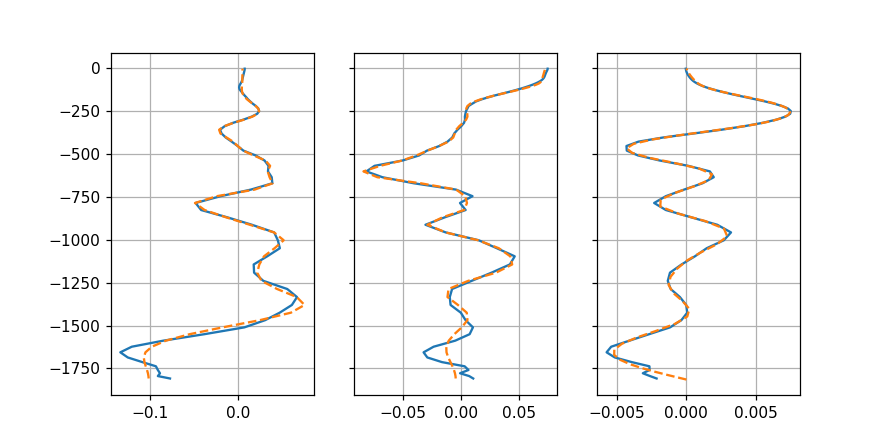

ek bclin: 3.1128742601021795 2.997317314147949 3.032724142074585 3.032724142074585
pe from w 3.9087652972042832


In [80]:
uu = simul.u[itsim, :, jsim, isim] - simul.ubar[itsim, jsim, isim]
urec = (uamp[1:,None]*pmod[1:,:]).sum(axis=0)
vv = simul.v[itsim, :, jsim, isim] - simul.vbar[itsim, jsim, isim]
vrec = (vamp[1:,None]*pmod[1:,:]).sum(axis=0)
# same for w
ww = simul.w[itsim, :, jsim, isim] 
wrec = (wamp[1:,None]*wmod[1:,:]).sum(axis=0)

fig, axs = plt.subplots(1, 3, sharex=False, sharey=True, figsize=(8,4))
axs[0].plot(uu, zr, urec, zr, "--")
axs[1].plot(vv, zr, vrec, zr, "--")
axs[2].plot(ww, zr, wrec, zw, "--")
for ax in axs:
    ax.grid(True)
    
print("ek bclin:", np.trapz(uu**2+vv**2, zr)/2., np.trapz(urec**2+vrec**2, zr)/2. \
      , ((urec**2+vrec**2)/2.*np.diff(zw)).sum(), ((uamp[1:]**2+vamp[1:]**2)*pnorm[1:]/2.).sum())
# pe from w is too high, which is probably because higher harmonics contribute (hence dividing by omega is not good)
print('pe from w', (wamp[1:]**2*wnorm[1:]).sum()/2./(2*np.pi/12.42/3.6e3)**2)

<IPython.core.display.Javascript object>


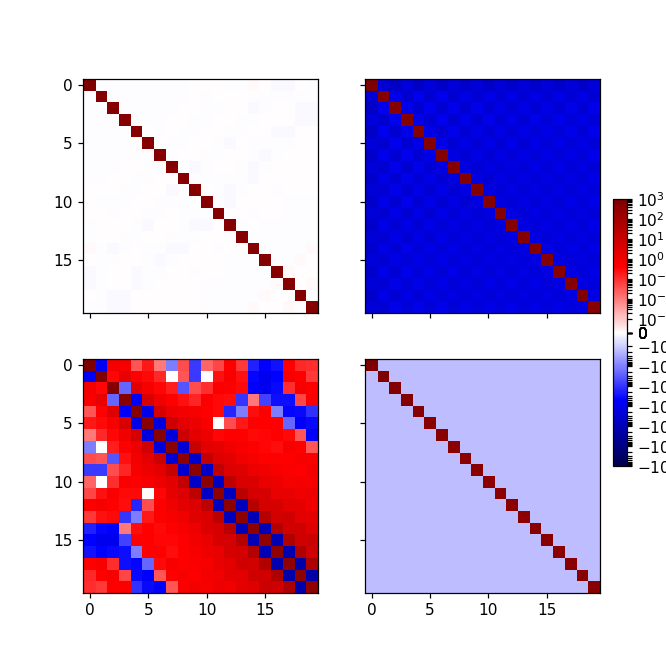

In [11]:
# check orthogonality
norm = colors.SymLogNorm(1e-3, linscale=1.0, vmin=-1e3, vmax=1e3)
cmap = "seismic"
wbod = .5*(wmod[:,1:]+wmod[:,:-1])

binorw = wmod[:,None,:]*wmod[None,:,:] /nsqb.mean()
binorb = wbod[:,None,:]*wbod[None,:,:] /nsqb.mean()

fig, bxs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(6,6))
axs = bxs.ravel()
im = axs[0].imshow(((pmod[:,None,:]*pmod[None,:,:])*np.diff(zw)).sum(axis=-1), norm=norm, cmap=cmap)
axs[1].imshow(np.trapz(pmod[:,None,:]*pmod[None,:,:], zr, axis=-1), norm=norm, cmap=cmap)
im = axs[2].imshow((.5*(nsqb[1:]+nsqb[:-1])[None,None,:]*binorb*np.diff(zw)).sum(axis=-1)+grav*binorw[:,:,-1], norm=norm, cmap=cmap)
axs[3].imshow(np.trapz(nsqb[None,None,:]*binorw, zw, axis=-1)+grav*binorw[:,:,-1], norm=norm, cmap=cmap)

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.3, 0.02, 0.4])
fig.colorbar(im, cax=cbar_ax)
        

<IPython.core.display.Javascript object>


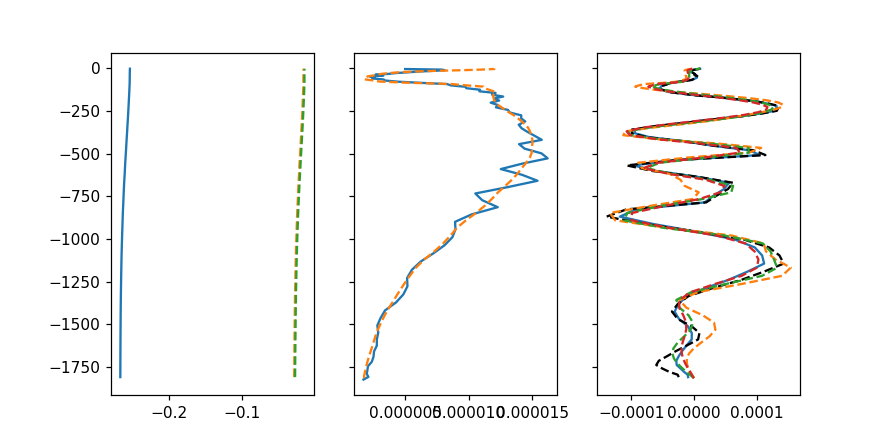

ep simu (gsw / roms tools) 0.7430391017651129 0.6109018821485902
ep from reco: 0.6272432804107666 0.3472794053246944 0.5175907544116487
ep from mode amps: 0.6272459626197815 0.3472799669086191 0.5109784778684368


In [149]:
# now for b (not easy)
# math is not really good but that is probably due to different buoyancy computed from roms tools compared to gsw
ntser = 360
# load temp, salt to recompute buoyancy
temp = simul.temp[:ntser,:,jsim,isim]
salt = simul.salt[:ntser,:,jsim,isim]
nt = temp.shape[0]

# compute buoyancy using gsw
pres = gsw.p_from_z(zr, simul.lat_rho[jsim,isim])
salt = gsw.SA_from_SP(salt, pres, simul.lon_rho[jsim,isim], simul.lat_rho[jsim,isim])
temp = gsw.CT_from_pt(salt, temp)
buoy = -9.81/1025*gsw.sigma0(salt,temp)
bmoy = np.nanmean(buoy, axis=0)
buoy_tser = buoy - bmoy[None,:]
buoy = buoy[itsim,:] - bmoy
bvf, pmid = gsw.Nsquared(salt, temp, pres, simul.lat_rho[jsim,isim], axis=1)
bvf = np.nanmean(bvf, axis=0)
zmid = -pmid[0,:]

# compute buoyancy using roms tools
brom = toolsf.get_buoy(temp[:,None,:], salt[:,None,:], np.tile(zr, (nt,1))[:,None,:] \
                       , np.tile(zw, (nt,1))[:,None,:], 1025.).squeeze()
broy = np.nanmean(brom, axis=0)
brom_tser = brom - broy[None,:]
brom = brom[itsim,:] - broy
brab = (brom*np.diff(zw)).sum()/abs(zw[0])

# reproject both buoyancy fields
bamr = (((brom*np.diff(zw))[None,:]*wbod).sum(axis=-1) + grav*brom[-1]/nsqb[-1]*wmod[:,-1])/wnorm
bamb = (((buoy*np.diff(zw))[None,:]*wbod).sum(axis=-1) + grav*buoy[-1]/nsqb[-1]*wmod[:,-1])/wnorm

# reconstruct buoyancy field
brec = (bamp[1:,None]*wmod[1:,:]).sum(axis=0)*nsqb
brer = (bamr[:,None]*wmod[:,:]).sum(axis=0)*nsqb
breb = (bamb[1:,None]*wmod[1:,:]).sum(axis=0)*nsqb

# plot mean buoyancy, perturbation and reconstructed fields
fig, axs = plt.subplots(1, 3, sharex=False, sharey=True, figsize=(8,4))
axs[0].plot(bmoy, zr, broy, zr, "--", bbaz, zr, "--")
axs[1].plot(bvf, zmid, nsqb, zw, "--")
axs[2].plot(buoy, zr, brom, zr, "--k")
axs[2].plot(brec, zw, "--")
axs[2].plot(brer, zw, "--")
axs[2].plot(breb, zw, '--')

print("ep simu (gsw / roms tools)", (.5*(buoy[:-1]+buoy[1:])**2/bvf*np.diff(zr)).sum()/2. \
                  , ((brom)**2/(nsqb[1:]+nsqb[:-1])*np.diff(zw)).sum())
print("ep from reco:", np.trapz(brec**2/nsqb, zw)/2., np.trapz(breb**2/nsqb, zw)/2., np.trapz(brer**2/nsqb, zw)/2.)
print("ep from mode amps:", (bamp[1:]**2*wnorm[1:]).sum()/2., (bamb[1:]**2*wnorm[1:]).sum()/2., (bamr[1:]**2*wnorm[1:]).sum()/2.)

<IPython.core.display.Javascript object>


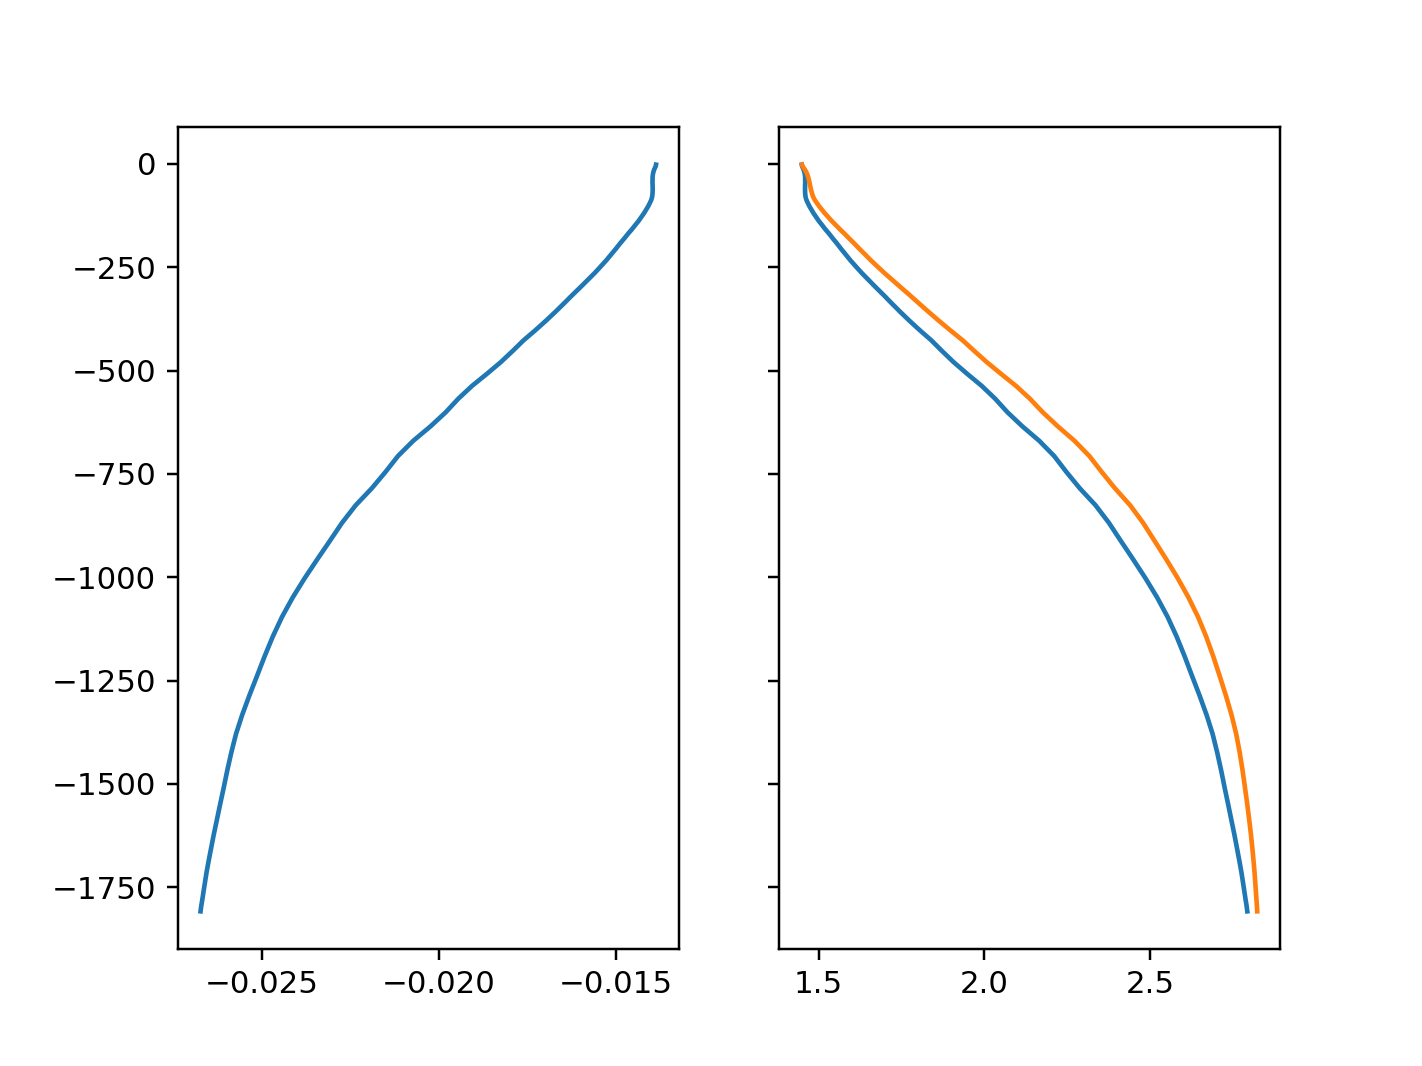

In [210]:
# computing buoyancy and rho and plotting (from mean temp, salt)
bbuoo = toolsf.get_buoy(temp.mean(axis=0)[None,None,:], salt.mean(axis=0)[None,None,:], zr[None,None,:], zw[None,None,:],1025).squeeze()
denso = toolsf.rho_eos(temp.mean(axis=0)[None,None,:], salt.mean(axis=0)[None,None,:], zr[None,None,:], zw[None,None,:],1025).squeeze()
dens1 = toolsf.rho1_eos(temp.mean(axis=0)[None,None,:], salt.mean(axis=0)[None,None,:], zr[None,None,:], 1025).squeeze()

fig, axs = plt.subplots(1, 2, sharey=True)
axs[0].plot(bbuoo, zr)
axs[1].plot(denso, zr, dens1, zr)

<IPython.core.display.Javascript object>


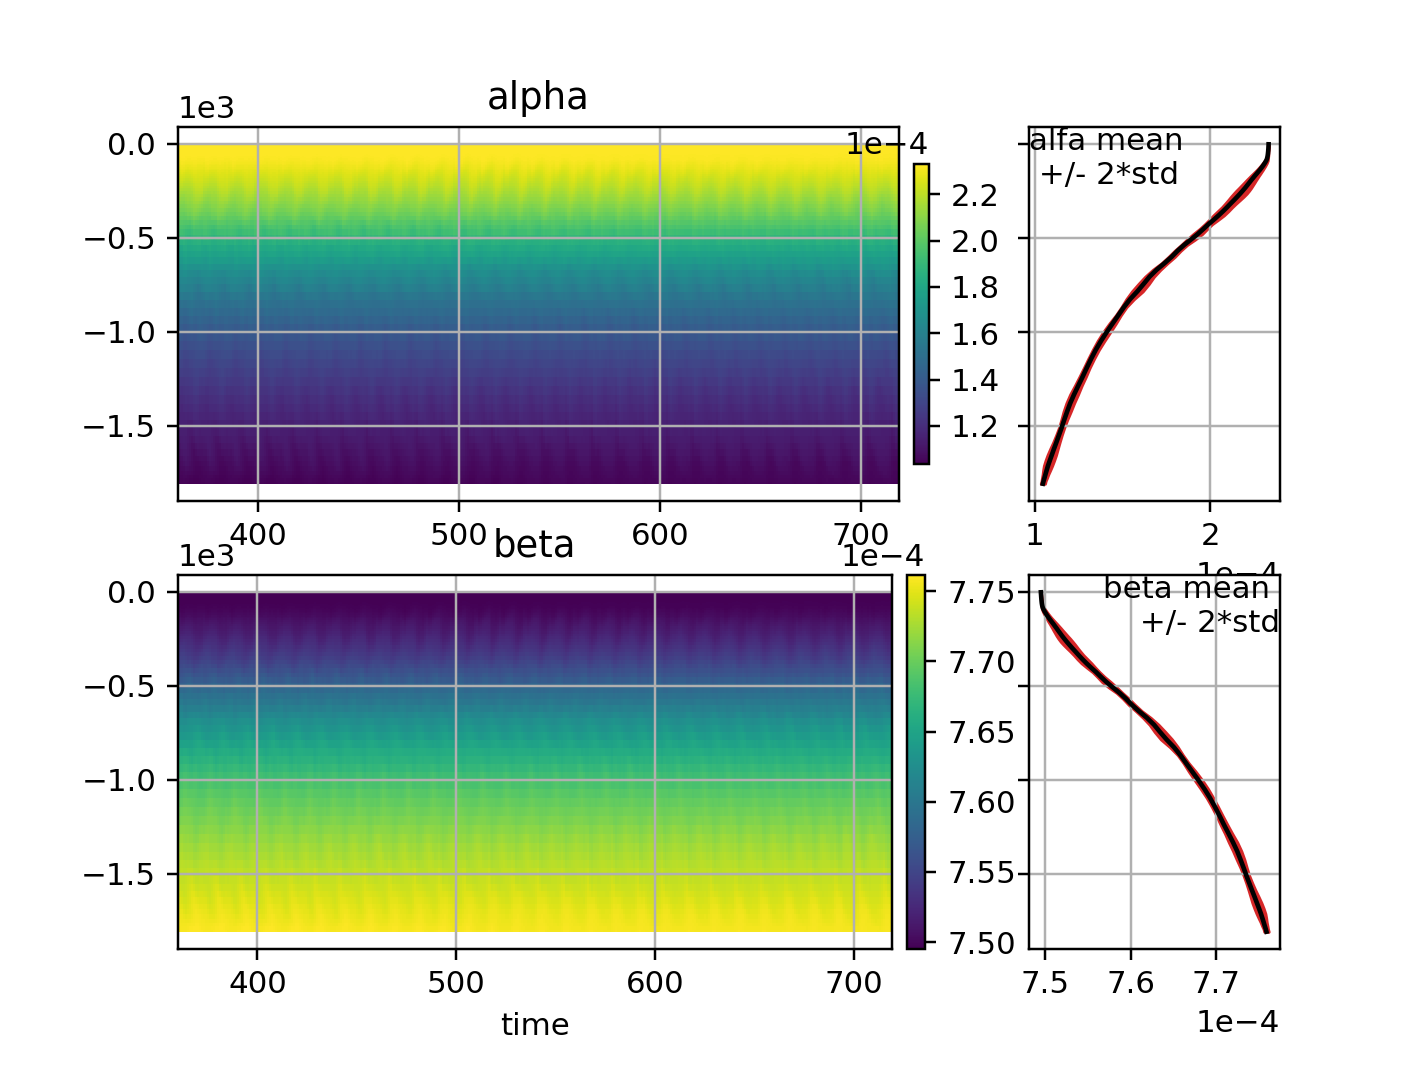

In [212]:
# rien à voir, mais test alfa, beta (evolution)
temp = simul.temp[:ntser,:,jsim,isim]
salt = simul.salt[:ntser,:,jsim,isim]
times = simul.time[:ntser]
alfa, beta = toolsf.alfabeta(temp,salt,1025.)

fig, axs = plt.subplots(2, 2, sharex=False, sharey=True, gridspec_kw = {'width_ratios':[3, 1]})

ax = axs[0,0]
hpc = ax.pcolormesh(times, zr, alfa.T)
cbar = plt.colorbar(hpc, ax=ax, fraction=.02, pad=.02)
cbar.formatter.set_powerlimits((-1, 1))
cbar.update_ticks()
ax.set_title("alpha")

ax = axs[1,0]
hpc = ax.pcolormesh(times, zr, beta.T)
cbar = plt.colorbar(hpc, ax=ax, fraction=.03, pad=.02)
cbar.formatter.set_powerlimits((-1, 1))
cbar.update_ticks()
ax.set_title("beta")
ax.set_xlabel('time')

ax = axs[0,1]
ax.plot(alfa.mean(axis=0), zr, "k")
ax.fill_betweenx(zr, alfa.mean(axis=0)-2*alfa.std(axis=0),alfa.mean(axis=0)+2*alfa.std(axis=0), color="tab:red")
ax.text(0,1,"alfa mean \n +/- 2*std", transform=ax.transAxes, va="top")
ax = axs[1,1]
ax.plot(beta.mean(axis=0), zr, "k")
ax.fill_betweenx(zr, beta.mean(axis=0)-2*beta.std(axis=0),beta.mean(axis=0)+2*beta.std(axis=0), color="tab:red")
ax.text(1,1,"beta mean \n +/- 2*std", transform=ax.transAxes, va="top", ha="right")

for ax in axs.ravel():
    ax.grid(True)
for ax in axs[:,1]: ax.ticklabel_format(style='sci',scilimits=(-2,3))
    
fig.savefig("/home/lahaye/working_on/Global_Stuff/pictures/alfabeta_LUCKYM2_tseries.png", magnification="auto", bbox_inches="tight", dpi=150)

In [191]:
ax.fill_betweenx?

<IPython.core.display.Javascript object>


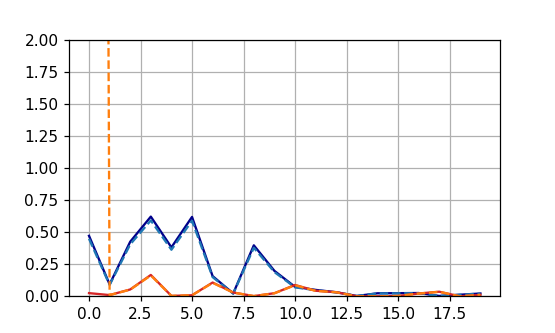

(0, 2)

In [159]:
# plot modal NRJ for comp with modal NRJ file
plt.figure(figsize=(5,3))
plt.plot(kemod/1e3, color="darkblue")
plt.plot((uamp**2+vamp**2)/2.*pnorm, "--")
plt.plot(pemod, color="tab:red")
plt.plot(bamp**2*wnorm/2, "--")
plt.grid(True)
plt.ylim([0, 2])

<IPython.core.display.Javascript object>


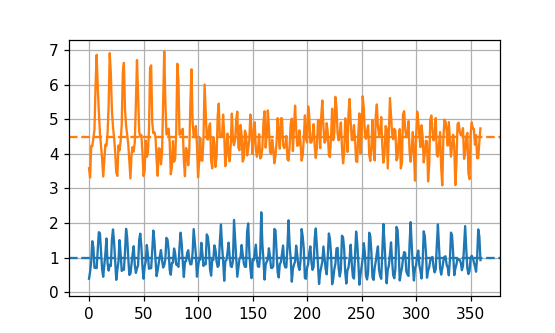

In [150]:
vamp = 1e-3
ke_tser = ((simul.u[:ntser,:,jsim,isim]**2/2+simul.v[:ntser,:,jsim,isim]**2/2.)*np.diff(zw)[None,:]).sum(axis=1)
pe_tser = (buoy_tser**2*(np.diff(zw)/(nsqb[1:]+nsqb[:-1]))[None,:]).sum(axis=1)

plt.figure(figsize=(5,3))
plt.plot(pe_tser)
plt.axhline(pe_tser.mean(), linestyle="--", color="tab:blue")
plt.plot(ke_tser)
plt.axhline(ke_tser.mean(), linestyle="--", color="tab:orange")
plt.grid(True)

<IPython.core.display.Javascript object>


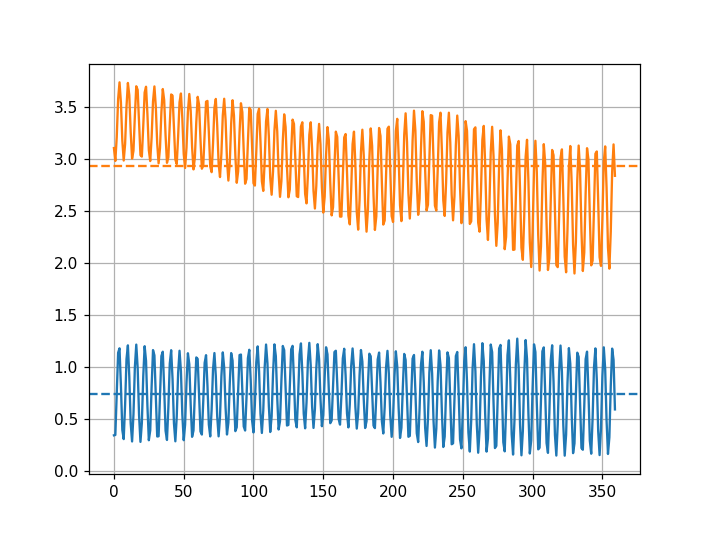

In [127]:
# use band pass filtered time series
bb, aa = sig.butter(4, np.array([1./1.2,1.2])*2./12.42, btype="band")

uu = simul.u[:ntser,:,jsim,isim] - simul.ubar[:ntser, jsim, isim][:,None]
vv = simul.v[:ntser,:,jsim,isim] - simul.vbar[:ntser, jsim, isim][:,None]
utser = sig.filtfilt(bb, aa, sig.detrend(uu, axis=0), method="gust", axis=0)
vtser = sig.filtfilt(bb, aa, sig.detrend(vv, axis=0), method="gust", axis=0)
btser = sig.filtfilt(bb, aa, sig.detrend(buoy_tser, axis=0), method="gust", axis=0)

vamp = 1e-3
ke_tser = ((utser**2+vtser**2)/2.*np.diff(zw)[None,:]).sum(axis=1)
pe_tser = (btser**2*(np.diff(zw)/(nsqb[1:]+nsqb[:-1]))[None,:]).sum(axis=1)

plt.figure()
plt.plot(pe_tser)
plt.axhline(pe_tser.mean(), linestyle="--", color="tab:blue")
plt.plot(ke_tser)
plt.axhline(ke_tser.mean(), linestyle="--", color="tab:orange")
plt.grid(True)

/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  


<IPython.core.display.Javascript object>


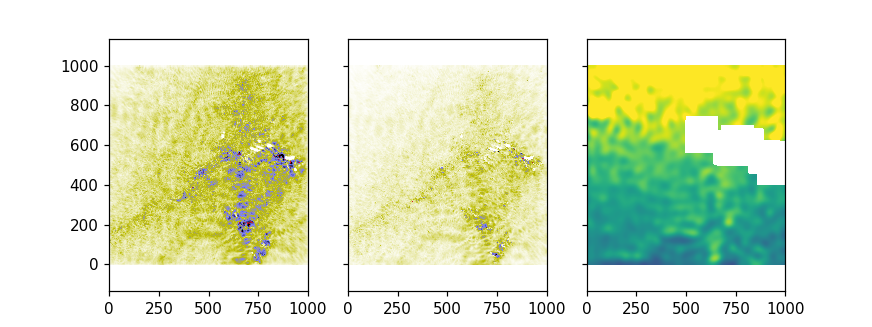

/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


KE/PE ratio, mean and theoretical: 2.48491 2.29669315058
value at my point, KE and PE: 2.40345 1.22738


/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


In [161]:
# test KE/PE partition from btrop/bcline calculation
ncbc = MFDataset(KRYPTON+"DIAG/NRJ_fluxes/luckym2_bclnrj_M2.?.nc", aggdim="eta_rho")
xp = ncbc.variables['xi_rho'][:]
yp = ncbc.variables['eta_rho'][:]
keavg = ncbc.variables['ekint_avg'][:]
peavg = ncbc.variables['epint_avg'][:]
ncbc.close()

ival, jval = abs(xi[xiok]-xp).argmin(), abs(eta[etok]-yp).argmin()
omega = 2*np.pi/(12.42*3600)
kprat = (omega**2+f0**2)/(omega**2-f0**2)
cmap = "gist_stern_r"

fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(8,3))
axs[0].pcolormesh(keavg, vmin=0, vmax=10, cmap=cmap)
axs[1].pcolormesh(peavg, vmin=0, vmax=10, cmap=cmap)
axs[2].pcolormesh(gaussian_filter(keavg/peavg, 20), vmin=1, vmax=3)

for ax in axs: ax.set_aspect(1)
    
print("KE/PE ratio, mean and theoretical:", np.nanmean(keavg/peavg), kprat)
print("value at my point, KE and PE:", keavg[jval,ival], peavg[jval,ival])